In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

data_path = "/content/drive/My Drive/SA/data"
model_path = "/content/drive/My Drive/SA/model"

In [ ]:
! pip install shap

In [ ]:
# Import needed libraries
import sys
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import itertools
from decimal import *

import xgboost
import shap

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv2D, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from sklearn.preprocessing import normalize

In [ ]:
features = np.load(os.path.join(data_path, 'coilfeatures_v7_6.npy'), allow_pickle=True, fix_imports=True, encoding='latin1')[:, 1:]
targets = np.load(os.path.join(data_path, 'coiltargets_v7_6.npy'))

In [ ]:
for f in range(features.shape[0]):
    features[f, 3] = float(features[f, 3])
    
features = features.astype(np.float64)

In [ ]:
labels = np.load(os.path.join(data_path, "featurelabels_real.npy"),allow_pickle = True, fix_imports=True,encoding='latin1').item()

feature_labels = np.load(os.path.join(data_path, "featurelabels_v7.npy"), fix_imports=True, encoding='latin1')[1:]

In [ ]:
feature_labels_new = []

for f in feature_labels:
    f = f.decode('utf-8')
    if (f in labels.keys()):
        rn = labels[f].replace(" ", "_")
        feature_labels_new.append(rn)
    else:
        feature_labels_new.append(f.replace(" ", "_"))

In [ ]:
features_norm = normalize(np.nan_to_num(features), norm='l2', axis=0, copy=True, return_norm=False)
# targets_norm = normalize(np.nan_to_num(targets), norm='l2', axis=0, copy=True, return_norm=True)


In [ ]:
clf = keras.models.load_model(os.path.join(model_path, 'dnn_v1_hgroup_6.h5'))


In [ ]:
train_data = np.expand_dims(features_norm, axis=1)
y = clf.predict(train_data)

In [ ]:
train_data.shape[0]

255900

In [ ]:
n_samples = 100

# select a set of background examples to take an expectation over
background = train_data[np.random.choice(train_data.shape[0], n_samples, replace=False)]
background = np.reshape(background,(n_samples, 369))

# explain predictions of the model on four images
explainer = shap.DeepExplainer(clf, background)

td = np.reshape(train_data,(-1, 369))
shap_values = explainer.shap_values(td[1:10])



expected_value = tf.keras.backend.get_value(explainer.expected_value)
df_td_1 = pd.DataFrame(td, columns=feature_labels_new)
df_td_2 = pd.DataFrame(td, columns=['F {}'.format(i) for i in range(1, 370)])

clf.predict(td[1:10])


array([[2.5525689e-04],
       [3.5208591e-06],
       [5.8781126e-07],
       [1.6186277e-06],
       [2.1629701e-06],
       [2.8106283e-06],
       [1.7958400e-06],
       [2.9720029e-06],
       [1.1242400e-06]], dtype=float32)

In [ ]:
shap_values[0].shape

(6, 369)

In [ ]:
# load JS visualization code to notebook
shap.initjs()
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0][0,:], X.iloc[0,:])
sample_number = 1
shap.force_plot(expected_value, shap_values[0][sample_number], df_td_2.iloc[sample_number])

Figure 1: Local shapley (shows the shap value for each sample)
#model base value = the average model output over the entire training dataset 
#model output = the output of model for the specific input sample. 
Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue


In [ ]:
# load JS visualization code to notebook
shap.initjs()

# visualize the training set predictions
shap.force_plot(expected_value, shap_values[0], df_td_2, link='logit')

Figure 2: global shapley (show the average importance of each feature)
*if we rotate figure 1 by 90 degrees plot it for all features and all samples and stack them horizontally, we can see the explanation over all examples in the dataset*
**x-axis : sample order by similarity**
**y-axis : model output value**
**Stacked SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it.**

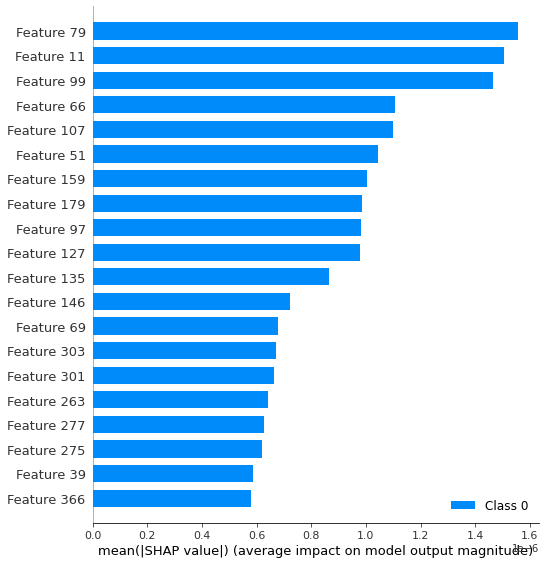

In [ ]:
shap.summary_plot(shap_values, td, plot_type="bar")

In [ ]:
df_td_2["F 1"]

0         0.000000
1         0.000034
2         0.000069
3         0.000103
4         0.000138
            ...   
255895    0.003277
255896    0.003312
255897    0.003346
255898    0.003381
255899    0.003415
Name: F 1, Length: 255900, dtype: float64

In [ ]:
shap.dependence_plot("F 1", shap_values[0], df_td_2)

IndexError: ignored

In [ ]:
shap.dependence_plot("RM", shap_values, td)

In [ ]:
td[0].shape

(369,)

In [ ]:
e.expected_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0002141], dtype=float32)>

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
# json.dumps(a.astype(float))
shap.force_plot(e.expected_value[0], shap_values[0][0], td[0])

In [ ]:
shap_values[0][0,:]

In [ ]:
background.shape

(100, 1, 369)

In [ ]:
train_data.shape

(255900, 1, 369)

In [ ]:
features.shape

(255900, 369)

In [ ]:
from keras.applications.vgg16 import preprocess_input
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
model = clf
e = shap.GradientExplainer(
    (model.input, model.output),
    map2layer(td, 1),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
